## Домашняя работа по современным сверточным нейросетям
**Kaggle: [competition](https://www.kaggle.com/c/sirius-spbsu-2022-entry-competition), [invite link](https://www.kaggle.com/t/d4064bcb01564f05bc5c0da9d141cd7c)**

**Kaggle deadline: 13.02.2022 23:59:00 +0000 GMT**

### Описание

В этой домашней работе нужно написать сверточную нейронную сеть для классификации изображений.

Вам предоставлен измененный датасет The Street View House Numbers ([SVHN](http://ufldl.stanford.edu/housenumbers/)). В нём содержится 50 тысяч (train) + 25 тысяч (test) RGB изображений размера 32х32 c цифрами, вырезанными из реальных фотографий номеров домов.

Задача: используя свёрточные нейронные сети, добиться максимальной точности классификации.

В данном домашнем задании нет никаких ограничений по архитектуре модели, но реализовывать в PyTorch её надо самим и обучить с нуля только на данном датасете, без внешних данных.

### Данные

В данном ноутбуке уже есть код для PyTorch, отвечающий за загрузку данных. Ниже приведено краткое описание формата хранения данных.

Каждый из файлов — сериализованный с помощью `pickle` c 4-ой версией протокола (которая стала версией по умолчанию в Python 3.8 и старше) python-словарик.

Список файлов:

- `meta` — метаданные датасета (например, названия классов)
- `data_train` — данные для обучения, 50К объектов
- `data_test` — данные для теста, 25К объектов, без правильных классов

Словарики с данными имеют следующие поля:

- `section` — имя части данных (train/test)
- `labels` — ground-truth классы, список из `N` чисел от 0 до 9
- `images` — numpy-массив размером `(N, 32, 32, 3)` с изображениями

### Оценка

Качество решения будет оцениваться по метрике accuracy (точность). Accuracy – это количество правильно классифицированных картинок к общему числу картинок в тестовом наборе. Публичный лидерборд рассчитывается по 30% тестовых данных, поэтому старайтесь не переобучаться под него.

```
accuracy = (correct classified) / (total # of examples)
```

В качестве решения вы должны прислать файл формата:

```
Id,Category
0, 3
1, 2
2, 9
3, 1
...
```

где:

- `Id` — порядковый номер объекта в тестовом датасете
- `Category` — предсказанный класс объекта

В данном ноутбуке уже есть код, подготавливающий файл решения.

### Эксперименты

Так как в обучении нейросетевой модели есть очень много различных гиперпараметров, в данном задании нужно будет делать много различных экспериментов. И будет очень полезно, и для вас самих, и для нас, проверяющих, наличие текстового описания всех, или по крайней мере самых интересных/важных в выборе итоговой модели, экспериментов с результатами в финальном ноутбуке. Наличие и подробность описания экспериментов будут входить в итоговую оценку за домашнее задание. Дедлайн на Kaggle специально поставлен немного раньше, чтобы у вас было время спокойно дописать отчет об экспериментах.

## Установка окружения

In [1]:
from IPython.display import clear_output
from google.colab import drive

!pip install wandb
!wandb login

drive.mount('/content/drive')
%cd /content/drive/MyDrive/collab_sandbox/Sirius/


clear_output()
!ls

artifacts    data		       models	    wandb
checkpoints  HW0_cnn_pytorch_pr.ipynb  predictions


## Решение

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import clear_output

In [3]:
import os
import pickle
from typing import Any, Callable, Optional, Tuple
from PIL import Image

In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor, Compose
from torchvision.datasets.vision import VisionDataset
import torchvision.transforms as T

In [5]:
import wandb
from datetime import datetime
import shutil
import importlib
from importlib.machinery import SourceFileLoader

Данные лежат в секции [Data](https://www.kaggle.com/c/sirius-spbsu-2022-entry-competition/data) kaggle-соревнования. <br>
Нужно скачать архив с данными и распаковать его. <br>
В переменной ниже указываем путь до датасета. <br>

Код для загрузки измененного датасета SVHN. Аргументы инициализации:

- `root` — строка, путь до директории с файлами датасета
- `is_train` — флаг, загружать часть для обучения или теста
- `transform` — преобразования изображения
- `target_transform` — преобразования класса изображения

In [7]:
dataset_root = "data/"

class SVHN(VisionDataset):

    def __init__(self,
                 root: str,
                 is_train: bool = True,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,
                 ) -> None:

        super().__init__(root, transform=transform, target_transform=target_transform)
        self.is_train = is_train

        meta_path = os.path.join(self.root, 'meta')
        with open(meta_path, "rb") as f:
            content = pickle.load(f)
            self.classes = content['label_names']
            self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

        data_path = os.path.join(self.root, 'data_train' if is_train else 'data_test')
        with open(data_path, "rb") as f:
            content = pickle.load(f)
            self.data = content['images']
            self.targets = content.get('labels')

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img = Image.fromarray(self.data[index].astype(np.uint8))
        target = self.targets[index] if self.is_train else len(self.classes)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def __len__(self) -> int:
        return len(self.data)
        
    def extra_repr(self) -> str:
        split = "Train" if self.train is True else "Test"
        return f"Split: {split}"

### Загрузка датасета

Загружаем часть датасета для обучения.

In [8]:
data = SVHN(
    root=dataset_root,
    is_train=True,
    transform=ToTensor(),
)

train_data, val_data = torch.utils.data.random_split(
    data, 
    [40000, 10000], 
    generator=torch.Generator().manual_seed(137),
)

batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

test_data = SVHN(
    root=dataset_root,
    is_train=False,
    transform=ToTensor(),
)

test_dataloader = DataLoader(
    test_data, 
    batch_size=batch_size,
)

Посмотрим, какой размерности батчи выдает data loader.

In [9]:
for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 3, 32, 32])
Shape of y:  torch.Size([64]) torch.uint8


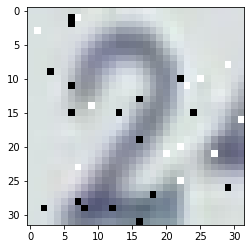

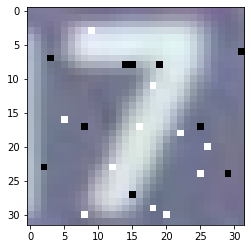

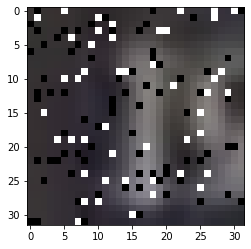

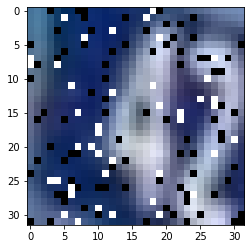

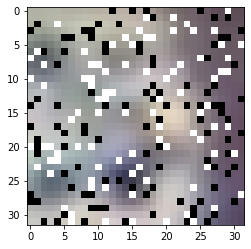

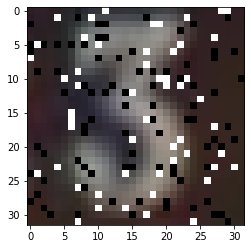

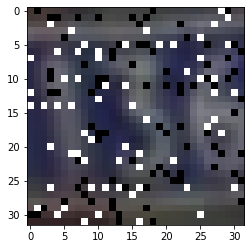

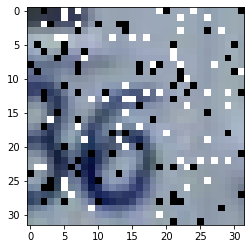

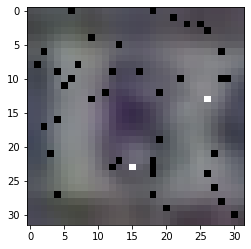

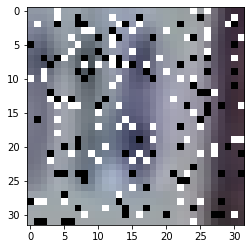

In [10]:
from matplotlib import pyplot as plt

for X, y in train_dataloader:
    for i in range(10):
        image_data = X[i].permute(1, 2, 0).cpu().numpy()
        plt.imshow(image_data, interpolation='nearest')
        plt.show()
    break

# Сначала перепишем тренировочный цикл в один класс, чтобы было удобнее перезапускать эксперименты

### Полезные ссылки
- [Pipeline_Versioning_with_W&B_Artifacts](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/wandb-artifacts/Pipeline_Versioning_with_W%26B_Artifacts.ipynb#scrollTo=l0B6av63rd4L)


In [11]:
class Experiment:
    def __init__(self, 
        model=None, 
        dataloader_train=None,
        dataloader_valid=None,
        dataloader_test=None,
        loss_func_class=None,
        estimate_func_class=None,
        experiment_config=None,
        optimizer_class=None,
        project_name=None,
        notebook_name=None,
        name_run="",
        model_description=""
        ): 
        assert notebook_name != None, f"notebook_name should be valid filename, but get {notebook_name}"

        # datasets
        self.dataloader_train = dataloader_train
        self.dataloader_valid = dataloader_valid
        self.dataloader_test = dataloader_test
        
        # wandb
        self.notebook_name = notebook_name
        self.project_name = project_name 
        self.experiment_config = experiment_config
        self.wandb_run = None
        self.name_run = name_run
        self.model_description = model_description
        self.model_name = "pytorch_model"
        self.model_artifact = None

        self.optimizer_class = optimizer_class
        self.loss_func_class = loss_func_class
        self.estimate_func_class = estimate_func_class

        self.model = model
        self.optimizer = None
        self.loss_func = None
        self.estimate_func = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device {self.device}")

        # prepare for experiment
        self.setup()
        self.unit_tests()

    def setup(self):
        self.model.to(self.device)
        self.optimizer = self.optimizer_class(self.model.parameters(), **self.experiment_config['optimizer'])

        self.loss_func = self.loss_func_class()
        self.estimate_func = self.estimate_func_class()

        # set model name
        date_time = self.get_date()
        self.model_name = f"{self.name_run}---{date_time}.pt"
        self.experiment_config['model_name'] = self.model_name

        # setup wandb
        # save model structure and weights to wandb
        self.model_artifact = wandb.Artifact(
            self.name_run, type="model",
            description=self.model_description,
            metadata=self.experiment_config)


    def get_date(self):
        now = datetime.now()
        date_time = now.strftime("%m_%d_%Y__%H:%M:%S")
        return date_time

    def unit_tests(self):
        # test training
        X, y = next(iter(self.dataloader_train))
        X, y = X.to(self.device), y.to(self.device)
        pred = self.model(X)
        loss = self.loss_func(pred, y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # test valid
        X, y = next(iter(self.dataloader_valid))
        X, y = X.to(self.device), y.to(self.device)
        pred = self.model(X)
        test_loss = self.estimate_func(pred, y).item()
        correct = (pred.argmax(1) == y).type(torch.float).sum().item()

        print("tests ok")


    def train(self):
        # https://colab.research.google.com/github/wandb/examples/blob/master/colabs/wandb-artifacts/Pipeline_Versioning_with_W%26B_Artifacts.ipynb#scrollTo=qrAWbBV1rd4I
        # если попытаться создать переменную чтобы не городить тут код возникает ошибка с wandb!
        with wandb.init(project=self.project_name, entity="dimweb",
                        settings=wandb.Settings(
                            start_method="thread", 
                            # symlink=False
                            ),
                        reinit=True,
                        name=self.name_run,
                        config=self.experiment_config,
                        # sync_tensorboard=True
                        ) as run:
            self.run = run
            
            # save model class
            self.save_model_class()

            # start train
            epochs = self.experiment_config['epochs']
            for i in range(epochs):
                print(f"Epoch: {i}")
                self.train_steps()
                self.valid_steps()
            
            # sync model
            self.wandb_save_model()
            
            print(f"train end")
    
    def save_model_class(self):
        # save class
        model_class_name = self.experiment_config['model_class_name']
        class_script_path_dest = f"{os.path.join(wandb.run.dir, model_class_name)}.py"
        class_script_path_src = f"./models/{model_class_name}.py"
        shutil.copy2(class_script_path_src, class_script_path_dest)
        self.model_artifact.add_file(class_script_path_dest)
        wandb.save(class_script_path_dest)

    def wandb_save_model(self):
        # wandb использует symlinks для того чтобы сохранять файлы
        # но из-за проблем с правами доступа возникает ошибка и модель нельзя сохранить
        # поэтому пришлось сохранять модель в дирректорию с самим запуском
        # https://docs.wandb.ai/guides/track/advanced/save-restore#example-of-saving-a-file-to-the-wandb-run-directory
        model_save_path = os.path.join(wandb.run.dir, self.model_name)
        torch.save(self.model.state_dict(), model_save_path)
        self.model_artifact.add_file(model_save_path)
        wandb.save(model_save_path)

        # save notebook
        notebook_path = os.path.join(wandb.run.dir, self.notebook_name)
        shutil.copy2(self.notebook_name, notebook_path)
        self.model_artifact.add_file(notebook_path)
        wandb.save(notebook_path)

        wandb.log_artifact(self.model_artifact)
    
    def train_steps(self):
        self.model.train()
        interval = self.experiment_config['check_interval']

        for batch, (X, y) in enumerate(self.dataloader_train):
            # Send data to training device
            X, y = X.to(self.device), y.to(self.device)
            # Compute prediction error
            pred = self.model(X)
            loss = self.loss_func(pred, y)
            # Backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            # Progress output
            if batch % interval == 0:
                wandb.log({"train_loss": loss.item()})

    def valid_steps(self):
        self.model.eval()
        test_loss, correct = 0, 0
        num_batches = len(self.dataloader_valid)
        size = len(self.dataloader_valid.dataset)

        with torch.no_grad():
            for X, y in self.dataloader_valid:
                X, y = X.to(self.device), y.to(self.device)
                pred = self.model(X)
                test_loss += self.estimate_func(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        test_loss /= num_batches
        correct /= size
        
        wandb.log({"val_loss": test_loss})
        wandb.log({"val_acc": correct})

    def load_model(self, artifact_name):
        assert artifact_name != ""
        with wandb.init(project=self.project_name, job_type="inference"):
            # artifact_name = "test_run:v7"
            model_artifact = wandb.use_artifact(artifact_name)
            model_dir = model_artifact.download()
            model_config = model_artifact.metadata
            model_path = os.path.join(model_dir, model_config['model_name'])
            # print(model_config)

            model_class_name = model_config['model_class_name']
            model_script_path = f"./artifacts/{artifact_name}/{model_class_name}.py"
            # get module by path https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path?rq=1 
            model_class = getattr(SourceFileLoader(model_class_name, model_script_path).load_module(), model_class_name)
            
            model_args = model_config['model_args']
            model = model_class(**model_args)

            model.load_state_dict(torch.load(model_path))
            self.model = model
            self.model.to(self.device)

    def test(self, artifact_name=""):
        self.load_model(artifact_name)
        print("model loaded to disk")
        predictions = []
        
        self.model.eval()

        with torch.no_grad():
            for X, _ in test_dataloader:
                X = X.to(self.device)
                pred = self.model(X).argmax(1).cpu().numpy()
                predictions.extend(list(pred))
        
        date_time = self.get_date()
        filename = f"./predictions/{self.name_run}---{date_time}.csv"
        with open(filename, 'w') as solution:
            print('Id,Category', file=solution)
            for i, label in enumerate(predictions):
                print(f'{i},{label}', file=solution)
        print("test end")

### Проверка кода на работоспособность

In [12]:
# google colab не обновляет файлы, поэтому приходится делать это вручную

def import_class(class_name):
    return getattr(importlib.reload(getattr(__import__(f"models.{class_name}"), class_name)), class_name)

TestModel = import_class("TestModel") 


exp_config = {
    "batch_size": 64,
    "check_interval": 100,
    "epochs": 1,
    "optimizer": {
        "lr": 1e-3
    },
    "model_name": "pytorch_model",
    "model_class_name": str(TestModel.__name__),
    "model_args": {
        "n_classes": 10
    }
}

model = TestModel(**exp_config['model_args'])
model.test()

# не хочу создавать глобальные переменные 
exp_params = {
    "model": model, 
    "dataloader_train": train_dataloader,
    "dataloader_valid": val_dataloader,
    "dataloader_test": test_dataloader,
    "loss_func_class": nn.CrossEntropyLoss,
    "estimate_func_class": nn.CrossEntropyLoss,
    "experiment_config": exp_config,
    "optimizer_class": torch.optim.Adam,
    "notebook_name": "HW0_cnn_pytorch_pr.ipynb",
    "project_name": "sirius_test",
    "name_run": "test_run",
    "model_description": "Test my new model",
}

experiment_test = Experiment(**exp_params)

testt1
Using device cuda
tests ok


In [ ]:
experiment_test.train()

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Epoch: 0


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


train end


train_loss,▅█▄▁▇▃▃
val_acc,▁
val_loss,▁
train_loss,2.31448
val_acc,0.1983
val_loss,2.33813


In [ ]:
experiment_test.test(artifact_name="test_run:v11")

model loaded to disk
test end


#### Видим что начальная модель работает, поэтому приступаем к экспериментам с различными архитектурами, первой на очереди будет LeNet

In [ ]:
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self, n_classes):
        super(LeNet5, self).__init__()

        self.hardtanh = nn.Hardtanh(-2, 2) # good results
        self.relu6 = nn.ReLU6() # good results
        self.celu = nn.CELU() # good results

        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=10*2, kernel_size=5, stride=1),
            nn.BatchNorm2d(10*2),
            self.hardtanh,
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=10*2, out_channels=16*2, kernel_size=5, stride=1),
            nn.Dropout(p=0.4),
            nn.BatchNorm2d(16*2),
            self.hardtanh,
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16*2, out_channels=120*2, kernel_size=5, stride=1),
            nn.Dropout(p=0.3),
            nn.BatchNorm2d(120*2),
            self.celu,
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=120*2, out_features=84*2),
            nn.Dropout(p=0.3),
            nn.BatchNorm1d(84*2),
            self.relu6,
            nn.Linear(in_features=84*2, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

In [ ]:
model = LeNet5(10)

exp_config = {
    "batch_size": 64,
    "check_interval": 100,
    "epochs": 30,
    "optimizer": {
        "lr": 1e-3
    }
}

# не хочу создавать глобальные переменные 
exp_params = {
    "model": model, 
    "dataloader_train": train_dataloader,
    "dataloader_valid": val_dataloader,
    "dataloader_test": test_dataloader,
    "loss_func_class": nn.CrossEntropyLoss,
    "estimate_func_class": nn.CrossEntropyLoss,
    "experiment_config": exp_config,
    "optimizer_class": torch.optim.Adam,
    "project_name": "sirius_test",
    "name_run": "lenet_model",
    "model_description": "Везде увеличены веса в 2 раза, использованы другие функции-активации, в отличии от оригинальной модели"
}

lenet_exp = Experiment(**exp_params)

Using device cuda
tests ok


In [ ]:
lenet_exp.train()

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


train end


train_loss,█▆▄▄▄▄▄▂▄▃▃▃▂▄▄▃▄▃▄▃▂▃▃▃▂▃▄▃▂▂▃▂▂▁▄▃▁▃▂▃
val_acc,▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇███████████████
val_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.77346
val_acc,0.8751
val_loss,0.47937


## AlexNet

⌊(n − k + 2*p + s)/s⌋

In [ ]:
(32 - 7 + 1 + 2*1) // 1

28

In [ ]:
(28 - 3) // 2

12

In [ ]:
(12 - 5 + 1 + 2*2) // 1

12

In [ ]:
(12 - 2) // 2

5

In [ ]:
(5 - 2) // 1

3

In [ ]:
25*150

3750

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, n_classes):
        super(AlexNet, self).__init__()
        
        self.conv = nn.Sequential( 
            nn.Conv2d(3, 100, kernel_size=7, stride=1, padding=1),
            nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(100, 150, kernel_size=5, padding=2), 
            nn.Dropout(p=0.4), 
            nn.BatchNorm2d(150),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(150, 250, kernel_size=3, padding=1),  
            nn.Dropout(p=0.4), 
            nn.BatchNorm2d(250),
            nn.ReLU(),
            nn.Conv2d(250, 250, kernel_size=3, padding=1), 
            nn.Dropout(p=0.4), 
            nn.BatchNorm2d(250),
            nn.ReLU(),
            nn.Conv2d(250, 150, kernel_size=3, padding=1), 
            nn.Dropout(p=0.2), 
            nn.BatchNorm2d(150),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
        )

        self.flat = nn.Flatten()
        self.classif = nn.Sequential(
            nn.Linear(3750, 2000), 
            nn.BatchNorm1d(2000),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2000, 1000), 
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(1000, n_classes)
        )
    
    def forward(self, x):
        x = self.conv(x)
        # print(x.shape)
        x = self.flat(x)
        # print(x.shape)
        x = self.classif(x)
        return x


In [ ]:
X, y = next(iter(train_dataloader))
model = AlexNet(10)
model(X)

In [ ]:
model = AlexNet(10)

exp_config = {
    "batch_size": 64,
    "check_interval": 100,
    "epochs": 30,
    "optimizer": {
        "lr": 1e-3
    }
}

# не хочу создавать глобальные переменные 
exp_params = {
    "model": model, 
    "dataloader_train": train_dataloader,
    "dataloader_valid": val_dataloader,
    "dataloader_test": test_dataloader,
    "loss_func_class": nn.CrossEntropyLoss,
    "estimate_func_class": nn.CrossEntropyLoss,
    "experiment_config": exp_config,
    "optimizer_class": torch.optim.Adam,
    "project_name": "sirius_test",
    "name_run": "alexnet_model",
    "model_description": "увеличил размерности слоёв до начального 100 с шагом 50"
}

alexnet_exp = Experiment(**exp_params)

Using device cuda
tests ok


In [ ]:
alexnet_exp.train()

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


train end


train_loss,█▅▃▃▄▃▃▂▂▂▁▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▂▁▂▁▁▁▂▁▁▁▂▁▁
val_acc,▁▅▆▇▆▇▇▇▇█████████████████████
val_loss,█▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▂▂▁▂▂▂▂▂▂▂▂▂▂▂
train_loss,0.13977
val_acc,0.8644
val_loss,0.64649


## VGG model

⌊(n − k + 2*p + s)/s⌋

initial vgg

In [ ]:
(224 - 3 + 2*1 + 1) // 1

224

In [ ]:
(224 - 2 + 2) // 2

112

In [ ]:
VGGNet = import_class("VGGNet")
conv_arch = ((2, 64), (2, 128), (3, 256))

net = VGGNet(10, conv_arch)

X = torch.randn(size=(2, 3, 32, 32))
net(X)

tensor([[-0.0653, -0.2325,  0.3089,  0.2128, -0.1975, -0.3278, -0.1966,  0.0223,
         -0.1714,  0.4040],
        [ 0.2187,  0.0765, -0.4695, -0.0996,  0.1647,  0.4403,  0.1246,  0.1584,
          0.0737, -0.5001]], grad_fn=<AddmmBackward0>)

In [ ]:
32 / 2**4

2.0

In [ ]:

exp_config = {
    "batch_size": 64,
    "check_interval": 100,
    "epochs": 30,
    "optimizer": {
        "lr": 1e-3
    },
    "model_name": "pytorch_model",
    "model_class_name": str(VGGNet.__name__),
    "model_args": {
        "n_classes": 10,
        "conv_arch": conv_arch
    }
}
model = VGGNet(**exp_config['model_args'])

# не хочу создавать глобальные переменные 
exp_params = {
    "model": model, 
    "dataloader_train": train_dataloader,
    "dataloader_valid": val_dataloader,
    "dataloader_test": test_dataloader,
    "loss_func_class": nn.CrossEntropyLoss,
    "estimate_func_class": nn.CrossEntropyLoss,
    "experiment_config": exp_config,
    "optimizer_class": torch.optim.Adam,
    "notebook_name": "HW0_cnn_pytorch_pr.ipynb",
    "project_name": "sirius_test",
    "name_run": "vggnet_model",
    "model_description": "применил блюр на датасет"
}

vggnet_exp = Experiment(**exp_params)

Using device cuda
tests ok


In [ ]:
vggnet_exp.train()

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17


train_loss,█▇▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▂▂▂▂▁▂▁▁▁▁▁▁
val_acc,▁▆▆▇▇▇▇▇████▇▇███
val_loss,█▃▃▂▂▂▂▂▁▁▁▁▂▂▁▁▁
train_loss,0.14439
val_acc,0.9295
val_loss,0.29324


KeyboardInterrupt: ignored

In [ ]:
vggnet_exp.test(artifact_name="vggnet_model:v12")

model loaded to disk
test end


## google lenet

⌊(n − k + 2*p + s)/s⌋ 

original size

In [ ]:
def conv_size(n=1, k=1, p=0, s=1):
    return (n - k + 2*p + s) // s

block 1

In [ ]:
conv_size(n=96, k=7, s=2, p=3)

48

In [ ]:
conv_size(n=48, k=3, s=2, p=0)

23

block 2

In [ ]:
conv_size(n=23, k=1, s=1, p=0)

23

In [ ]:
conv_size(n=23, k=3, s=1, p=1)

23

In [ ]:
conv_size(n=23, k=3, s=2, p=1)

12

inception block

![](https://d2l.ai/_images/inception.svg)

inception path 1 - same output

inception path 2

In [ ]:
# 1x1 same
conv_size(n=12, k=3, p=1, s=1)

12

inception path 3

In [ ]:
conv_size(n=12, k=5, p=2, s=1)

12

inception path 4

In [ ]:
conv_size(n=12, k=3, p=1, s=1)

12

In [ ]:
64+128+64

256

block 3

In [ ]:
conv_size(n=12, k=3, p=1, s=2)

6

In [ ]:
conv_size(n=6, k=3, p=1, s=2)

3

In [ ]:
96 // 2**5

3

block 5

In [ ]:
conv_size(n=12, k=3, p=1, s=1)

In [ ]:
384*2+128*2

1024

inception block не меняет размер нашей картинки.

In [ ]:
GoogleLeNet = import_class("GoogleLeNet")
    
X = torch.rand(size=(2, 3, 32, 32))
GoogleLeNet(10)(X).shape

torch.Size([2, 10])

In [ ]:
128+192+96+64

480

In [ ]:
192+208+48+64

512

In [ ]:
256+320+128+128

832

#### Train GoogleLeNet 

In [ ]:
GoogleLeNet = import_class("GoogleLeNet")

exp_config = {
    "batch_size": 64,
    "check_interval": 100,
    "epochs": 30,
    "optimizer": {
        "lr": 1e-3
    },
    "model_name": "pytorch_model",
    "model_class_name": str(GoogleLeNet.__name__),
    "model_args": {
        "n_classes": 10,
    }
}
model = GoogleLeNet(**exp_config['model_args'])

# не хочу создавать глобальные переменные 
exp_params = {
    "model": model, 
    "dataloader_train": train_dataloader,
    "dataloader_valid": val_dataloader,
    "dataloader_test": test_dataloader,
    "loss_func_class": nn.CrossEntropyLoss,
    "estimate_func_class": nn.CrossEntropyLoss,
    "experiment_config": exp_config,
    "optimizer_class": torch.optim.Adam,
    "notebook_name": "HW0_cnn_pytorch_pr.ipynb",
    "project_name": "sirius_test",
    "name_run": "google_lenet_model",
    "model_description": "изменил maxpool на average pool"
}

google_lenet_exp = Experiment(**exp_params)

Using device cuda
tests ok


In [ ]:
google_lenet_exp.train()

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


train end


train_loss,█▅▄▃▄▄▃▂▃▃▂▂▂▃▂▁▂▂▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▃▅▅▅▅▅▅▆▆▆▇▆▇▇▇▇▇▇█▇▇███████
val_loss,█▆▅▄▃▃▃▃▃▂▂▃▂▃▁▁▁▃▂▂▂▂▂▁▂▁▂▁▂▃
train_loss,0.2566
val_acc,0.8277
val_loss,0.81546


In [ ]:
google_lenet_exp.test(artifact_name="google_lenet_model:v0")

## ResNet

In [25]:
ResNet = import_class("ResNet")

net = ResNet(10)
X = torch.rand(size=(2, 3, 32, 32))
net(X).shape       

torch.Size([2, 10])

In [ ]:
ResNet = import_class("ResNet")

exp_config = {
    "batch_size": 64,
    "check_interval": 100,
    "epochs": 30,
    "optimizer": {
        "lr": 1e-3
    },
    "model_name": "pytorch_model",
    "model_class_name": str(ResNet.__name__),
    "model_args": {
        "n_classes": 10,
    }
}
model = ResNet(**exp_config['model_args'])

# не хочу создавать глобальные переменные 
exp_params = {
    "model": model, 
    "dataloader_train": train_dataloader,
    "dataloader_valid": val_dataloader,
    "dataloader_test": test_dataloader,
    "loss_func_class": nn.CrossEntropyLoss,
    "estimate_func_class": nn.CrossEntropyLoss,
    "experiment_config": exp_config,
    "optimizer_class": torch.optim.Adam,
    "notebook_name": "HW0_cnn_pytorch_pr.ipynb",
    "project_name": "sirius_test",
    "name_run": "resnet_model",
    "model_description": "дефолтная упрощенная модель"
}

google_lenet_exp = Experiment(**exp_params)